In [ ]:
import numpy as np
import gym
import random
import time
import tqdm

## Step 1: Create the environment 🕹️
- Here we'll create the Taxi-v3 environment 🚕. 

[Environment]

Our environment looks like this: 
- It's a **5x5 grid world**
- Our 🚕 is spawned **randomly** in a square. 
- The passenger is **spawned randomly in one of the 4 possible locations** (R, B, G, Y) and wishes to go in one of the **4 possibles locations too**.

The reward system:
- -1 for each timestep
- +20 for successfully deliver the passenger
- -10 for illegal actions (pickup or putdown the passenger at the outside of the destination).

In [ ]:
env = gym.make('Taxi-v3')
env.reset()
env.render()

In [ ]:
env.reset()
env.step(1)

In [ ]:
env.render()

### Read the following description ([reference](https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py))

    The Taxi Problem
    from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
    by Tom Dietterich
    
    Description:
    There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.
    
    Observations:
    There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.
    Note that there are 400 states that can actually be reached during an episode. The missing states correspond to situations in which the passenger is at the same location as their destination, as this typically signals the end of an episode.
    Four additional states can be observed right after a successful episodes, when both the passenger and the taxi are at the destination.
    This gives a total of 404 reachable discrete states.
    
    Passenger locations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    - 4: in taxi
    
    Destinations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    
    Actions:
    There are 6 discrete deterministic actions:
    - 0: move south
    - 1: move north
    - 2: move east
    - 3: move west
    - 4: pickup passenger
    - 5: drop off passenger
    
    Rewards:
    There is a default per-step reward of -1,
    except for delivering the passenger, which is +20,
    or executing "pickup" and "drop-off" actions illegally, which is -10.
    
    Rendering:
    - blue: passenger
    - magenta: destination
    - yellow: empty taxi
    - green: full taxi
    - other letters (R, G, Y and B): locations for passengers and destinations
    
    state space is represented by:
        (taxi_row, taxi_col, passenger_location, destination)

### How to read a state from the Rendering

Based on the above description and playing a little bit with the renderer, I realised the grid is represented this way:

Starting from the top-left, moving row-wise, and ending to the bottom-right, each cell takes 20 different sub-states (zero to 19), where each sub-state is determined by the location of the passenger (one of the 5 possible options) times ($\times$) the location of the destination (one of the four options). 

For example, if we see this rendering:
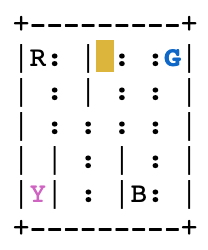
First of all, the location of the taxi (indicated by yello rectangle) is in the top row and third column, so the state should be between 40 to 59.
Then we see that the location of the passenger (indicated by blue color) is in `G` cell, which shows that the sub-state must be ones of {4, 5, 6, 7}, **(e.g. {0, 1, 2, 3} are for the case when passenger is in `R` and destination is in four possible location; Please note the order of the locations in the above description)**. Since the destination (shown by Magenta color) is at `Y` cell, the total sub-state will be 4+2=6.

Hence, the full state will be 40+4+2=46.

Also note that you can get the current state via:

In [ ]:
env.s

## Define the epsilon-greedy policy 🤖

Epsilon-Greedy is a policy that handles the exploration/exploitation trade-off

Epsilon Greedy:

- *With probability 1 - ɛ* : we do **exploitation** (aka our agent selects the action with the highest state-action pair value).

- *With probability ɛ*: we do **exploration** (trying random action).

And as the training goes, **we progressively reduce the epsilon value** since we will **need less and less exploration and more exploitation**.

## Step 2: Define the Q-Learning algorithm and train our agent 🧠
- Now we implement the Q learning algorithm:
[Q-Learning]

In [ ]:
total_episodes = 25000        # Total number of training episodes
total_test_episodes = 100     # Total number of test episodes
action_str = {0: "south", 1: "north", 2: "east", 3: "west", 4: "pickup", 5: "drop"}

class Qlearner:
    def __init__(self, env):
        # Create the Q-table and initialize it
        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))
        self.env = env
        self.env.reset()
        self.is_episode_over = False
        self.learning_rate = 0.01  # Learning rate
        self.gamma = 0.99  # Discounting rate
        self.max_steps = 200  # Max steps per episode
        self.epsilon = 1.0  # Exploration probability at start
        self.max_epsilon = 1.0  # Exploration probability at start
        self.min_epsilon = 0.001  # Minimum exploration probability 
        self.decay_rate = 0.01  # Exponential decay rate for exploration prob
        
    def get_epsilon_greedy_action(self):
        z = random.uniform(0, 1)
        if z <= self.epsilon:
            action = np.random.choice(self.q_table.shape[1])
            # OR: action = env.action_space.sample()
        else:
            action = np.argmax(self.q_table[self.env.s, :])
        return action
    
    def train(self, total_episodes=total_episodes):
        episode_reward = 0
        pbar = tqdm.tqdm(range(total_episodes))
        for episode in pbar:
            if not (episode % 100):
                pbar.set_description(f'sample episode_reward= {episode_reward}')
            self.env.reset()
            episode_reward = self.run_training_episode()
            self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.decay_rate * episode)
            
    def run_training_episode(self):
        episode_reward = 0
        for n in range(self.max_steps):
            action = self.get_epsilon_greedy_action()
            current_state = self.env.s
            next_state, next_reward, is_episode_over, _ = self.env.step(action)
            episode_reward += next_reward
            next_state_max_value = self.q_table[next_state, :].max()
            # Update the q_table
            step = next_reward + self.gamma * next_state_max_value - self.q_table[current_state, action]
            self.q_table[current_state, action] += self.learning_rate * step
            if is_episode_over:
                return episode_reward
        return episode_reward
    
    def test(self, total_test_episodes=total_test_episodes):
        for episode in range(total_test_episodes):
            self.env.reset()
            # self.env.render()
            episode_reward = self.run_test_episode()
            # self.env.render()
            print(f'episode_reward = {episode_reward}')
            print('---------------------------------\n')
            time.sleep(2)
            
    def run_test_episode(self):
        episode_reward = 0
        for _ in range(self.max_steps):
            # Display the traveling taxi:
            self.env.render()
            action = np.argmax(self.q_table[self.env.s, :])
            next_state, next_reward, is_episode_over, _ = self.env.step(action)
            episode_reward += next_reward
            if is_episode_over:
                return episode_reward
        return episode_reward

### Q-learner Instatiation and Training

In [ ]:
qlearner = Qlearner(env)
qlearner.train(total_episodes)

### Inference

In [ ]:
qlearner.test(5)